In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu
import math

Start import
Working on midway2-0462.rcc.local with the following versions 
and installation paths:
strax
	v0.15.1	/dali/lgrandi/strax/strax/strax
straxen
	v0.18.2	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
kr_runs_1 = ['018159','018160','018161','018162'] # 03/05/2021

In [4]:
kr_runs_2 = ['018207','018210','018212','018215','018219','018221','018223','018225',
             '018227','018229','018231','018233','018235','018237','018239','018241',
             '018243','018245','018247','018249'] # 04/05/2021

In [5]:
def diffusion_analysis(run_kr, area_cut=(5e3,1.1e4), fit_range=(1,1500), plot = False ):
    run = int(run_kr)
    events = st.get_df(run_kr,'event_info_double',progress_bar=False)
    if(plot): ddu.plot_area_width_aft_kr(events, run_kr)
    mask_singleS1 = ddu.mask_KrSingleS1(events)
    if(plot): ddu.plot_area_width_aft_kr(events[mask_singleS1], run_kr)
    e1 = events[mask_singleS1]
    mask_awt = ddu.mask_s2_area_width_aft_kr(e1,run_kr,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),plot=plot)
    e2 = events[mask_singleS1 & mask_awt]
    vd, vd_err, cathodedt, gatedt, s2shift = drift_velocity_kr(e1, run_kr, plot=plot)
    d, d_err = ddu.diffusion_constant_kr(e2,run_kr,fit_range=(1,1500),vd = vd,plot=plot)
    return run, vd, vd_err, d, d_err, cathodedt, gatedt, s2shift

In [6]:
from scipy.ndimage import gaussian_filter1d
def drift_velocity_kr(events, run_id, low = 10, high = 3000, binning = 500, plot=False):
    if 'area_ratio' in events: pass
    else: events.insert(1, 'area_ratio', np.divide(events['cs2_a'],events['cs1_a']))
    events = events[events['area_ratio']<1e3]
    
    # cathode drop-off
    dt = np.linspace(low, high, binning)
    hdtime = Hist1d(events['drift_time']/1e3, bins=dt)
    hfilt = gaussian_filter1d(hdtime,8)
    cathodedt = dt[np.where(np.gradient(hfilt)==np.gradient(hfilt).min())[0][0]]
    
    if plot:
        plt.figure(figsize=(12,6))
        hdtime.plot(color='b',label='data')
        plt.ylabel("events", ha='right', y=1)
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1)
        plt.title(f'run {run_id}',fontsize=14)
        plt.axvline(x=cathodedt,linewidth=1,linestyle='-', color='r',label=f'$cathode = {cathodedt:.1f}~\mu$s')
        plt.legend(fontsize=14)

    mh = Histdd(events['drift_time']/1e3, events['area_ratio'],
            bins=(np.linspace(low, high, binning), np.logspace(0, 5, 200)))
    
    if plot:
        plt.figure(figsize=(12,6))
        mh.plot(log_scale=True, cblabel='events')
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
        plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        plt.yscale('log')
        plt.xlim(1500,high)
        plt.axvline(x=cathodedt,linewidth=1,linestyle='-', color='r',label=f'$cathode = {cathodedt:.1f}~\mu$s')
    
    # gate drift time
    dts = np.linspace(1, 20, 200)
    mh_low = Histdd(events['drift_time']/1e3, events['area_ratio'],
            bins=(dts, np.linspace(0, 200, 200)),axis_names=['drift_time', 'area_ratio'])
    median = mh_low.percentile(50, axis='area_ratio')
    mfilt = gaussian_filter1d(median, 4)
    gatedt = dts[np.where(np.gradient(mfilt)==np.gradient(mfilt).min())[0][0]] #maximum slope
    s2shift = dts[np.where((mfilt[10:]-mfilt[50:].mean())<3)[0][0]] # beginning of flat part
    vd = 1485/(cathodedt-gatedt)
    vd_err = vd*(10/cathodedt)
    if plot:
        plt.figure(figsize=(12,6))
        mh_low.plot(log_scale=False, cblabel='events')
        plt.xlabel("drift time ($\mu$s)", ha='right', x=1,fontsize=12)
        plt.ylabel("cS2/cS1", ha='right', y=1,fontsize=12)
        plt.title(f'run {run_id}',fontsize=14)
        median.plot(label='median')
        plt.plot(dts[1:],mfilt,label='filtered median')
        plt.axvline(x=s2shift,linewidth=1,linestyle='--',color='violet',label=f'$S2~shift = {s2shift:.1f}~\mu$s')
        plt.axvline(x=gatedt,linewidth=1,linestyle='--',color='r',label=f'$gate = {gatedt:.1f}~\mu$s')
        plt.axhline(y=mfilt[50:].mean(),color='b',label='mean')
        plt.legend(fontsize=14)
        print(f'Drift velocity = {vd:.3f}~mm/$\mu$s')
    return vd, vd_err, cathodedt, gatedt, s2shift

Drift velocity = 0.675~mm/$\mu$s
Diffusion constant = 44.28 +/- 0.09 cm$^2$/s 


(18162,
 0.6749519604396876,
 0.003063693597549454,
 44.284956692680296,
 0.08803731550789767,
 2203.066132264529,
 2.909547738693467,
 4.4371859296482405)

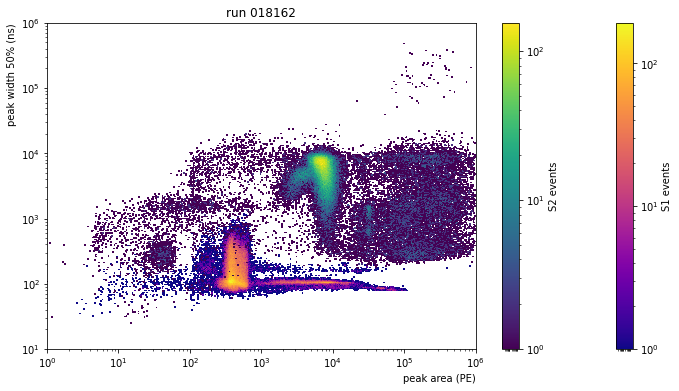

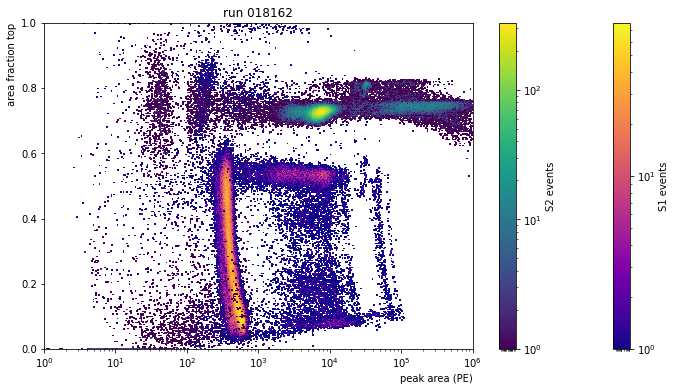

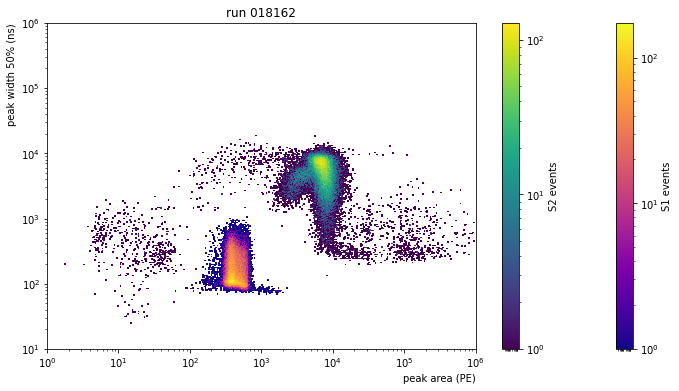

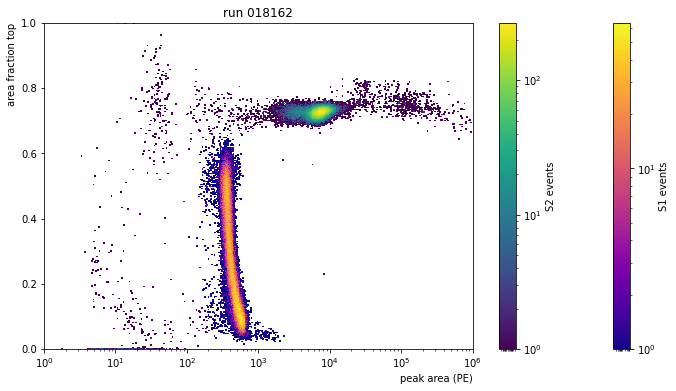

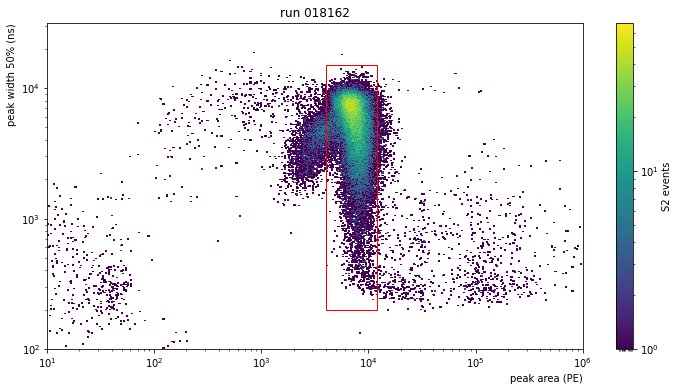

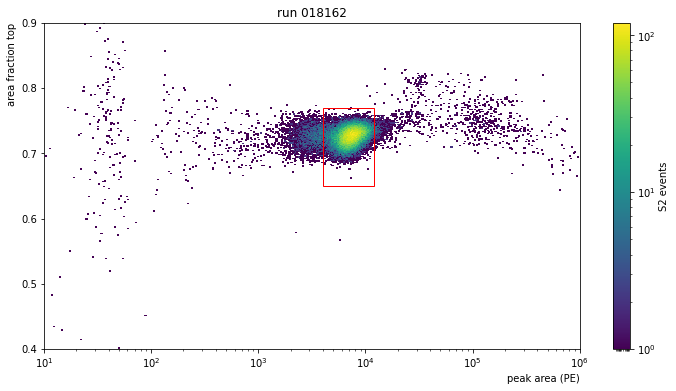

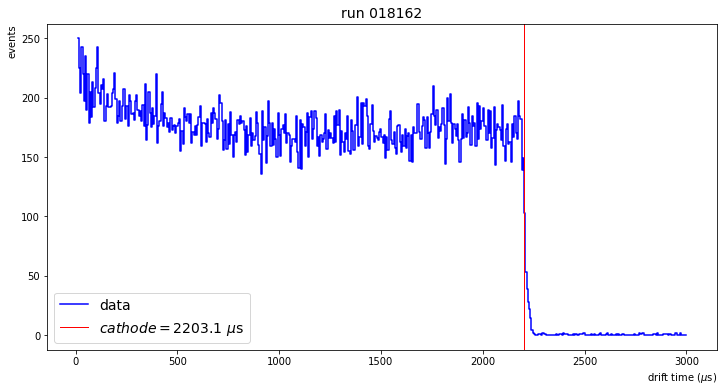

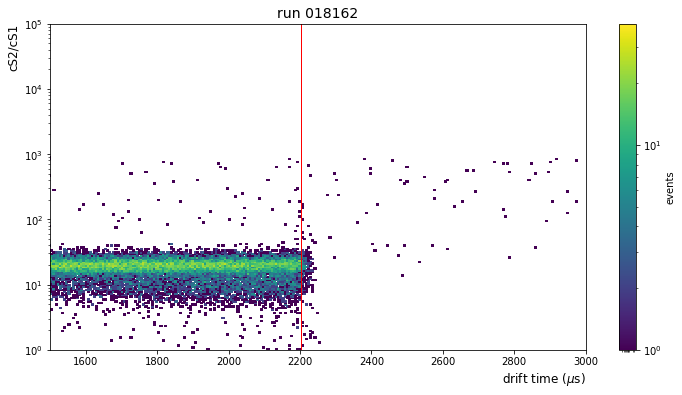

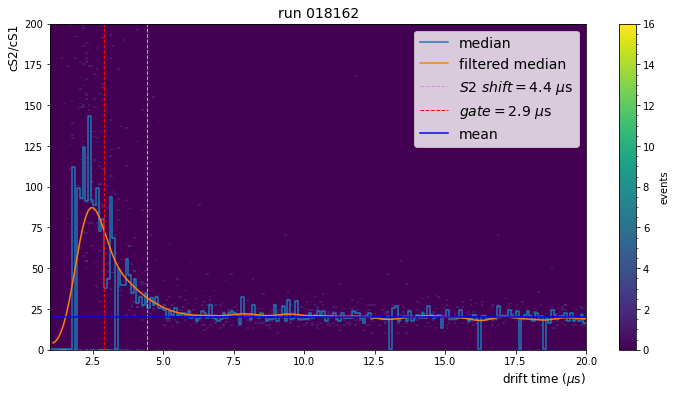

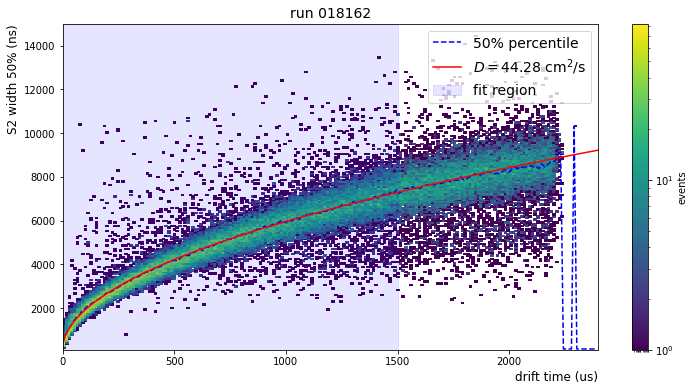

In [8]:
diffusion_analysis(kr_runs_1[3],area_cut=(4e3,1.2e4),fit_range=(1,1500), plot = True)

In [11]:
def kr_drift_diffusion_analysis(kr_runs,runrange=1):
    nn = len(kr_runs)
    runs, vd, vd_err = np.zeros(nn), np.zeros(nn), np.zeros(nn)
    d, d_err = np.zeros(nn), np.zeros(nn)
    cc, gg, ss = np.zeros(nn), np.zeros(nn), np.zeros(nn)
    for i, run in enumerate(kr_runs):
        runs[i], vd[i], vd_err[i], d[i], d_err[i], cc[i], gg[i], ss[i] = diffusion_analysis(run, area_cut=(4e3,1.2e4))
    rint = range(int(runs[0]), int(runs[-1]+1),runrange)
    # plot diffusion vs runs
    plt.figure(figsize=(12,6))
    plt.xlabel("run", ha='right', x=1,fontsize=14)
    plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1,fontsize=14)
    plt.errorbar(runs, d, yerr = d_err, fmt='s',c='b',label='diffusion constant')
    mean1 = d[d>0].mean()
    std1 = d[d>0].std()/np.sqrt(np.size(d))+d_err[d>0].mean()
    plt.axhline(mean1,color='r',label=f'$D = {mean1:.2f} \pm {std1:.2f}$ cm$^2$/s')
    plt.xticks(rint)
    #plt.ylim(41,45)
    plt.legend(fontsize=14)
    
    ### cathode drop-off
    plt.figure(figsize=(12,6))
    plt.xlabel("run", ha='right', x=1,fontsize=14)
    plt.ylabel("cathode drift time ($\mu$s)", ha='right', y=1,fontsize=14)
    plt.errorbar(runs,cc,yerr=10,fmt='s',color='b',label='cathode drift time')
    cm1, cs1 = cc.mean(), cc.std()/np.sqrt(np.size(cc))
    plt.axhline(cm1, color='r',label=f'$cathode = {cm1:.1f} \pm {cs1:.1f}$ mm/$\mu$s')
    #plt.ylim(2320,2400)
    plt.xticks(rint)
    plt.legend(fontsize=14)

    ### gate drift time
    plt.figure(figsize=(12,6))
    plt.xlabel("run", ha='right', x=1,fontsize=14)
    plt.ylabel("gate drift time ($\mu$s)", ha='right', y=1,fontsize=14)
    plt.errorbar(runs,gg,yerr=1,fmt='s',color='g',label='gate drift time')
    gm1, gs1 = gg[gg>0].mean(), (gg[gg>0].max()-gg[gg>0].min())/2
    plt.axhline(gm1,color='r',label=f'$gate = {gm1:.1f} \pm {gs1:.1f}$ mm/$\mu$s')
    plt.legend(fontsize=14)
    plt.xticks(rint)
    #plt.ylim(1,5)

    ### S2 shift time
    plt.figure(figsize=(12,6))
    plt.xlabel("run", ha='right', x=1,fontsize=14)
    plt.ylabel("S2 shifted time ($\mu$s)", ha='right', y=1,fontsize=14)
    plt.errorbar(runs,ss,yerr=1,fmt='s',color='violet',label='S2 shifted time')
    sme1, sst1 = ss[ss>0].mean(), (ss[ss>0].max()-ss[ss>0].min())/2
    plt.axhline(sme1,color='r',label=f'$S2 shift = {sme1:.1f} \pm {sst1:.1f}$ mm/$\mu$s')
    plt.legend(fontsize=14)
    plt.xticks(rint)
    #plt.ylim(3,8)

    # drift velocity
    plt.figure(figsize=(12,6))
    plt.xlabel("run", ha='right', x=1,fontsize=14)
    plt.ylabel("drift velocity (mm/$\mu$s)", ha='right', y=1,fontsize=14)
    plt.errorbar(runs,vd,yerr=vd_err,fmt='s',color='r',label='drift velocity')
    m1 = vd[vd>0].mean()
    s1 = vd[vd>0].std()/np.sqrt(np.size(vd))+vd_err[vd>0].mean()+vd_err[vd>0].mean()
    plt.axhline(m1,color='r',label=f'$v_D = {m1:.3f} \pm {s1:.3f}$ mm/$\mu$s')
    #plt.ylim(0.62,0.64)
    plt.xticks(rint)
    plt.legend(fontsize=14)
    return mean1, std1, m1, s1

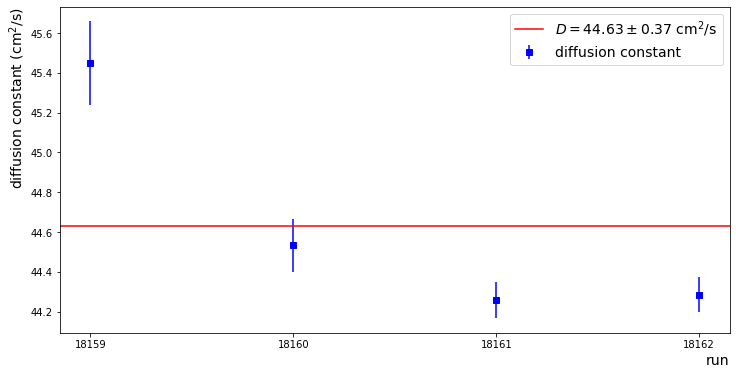

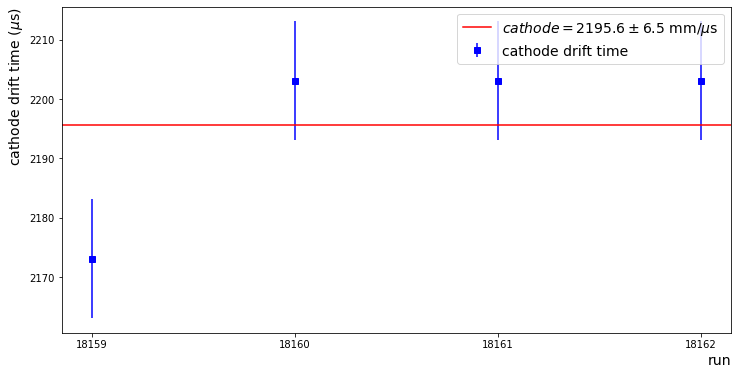

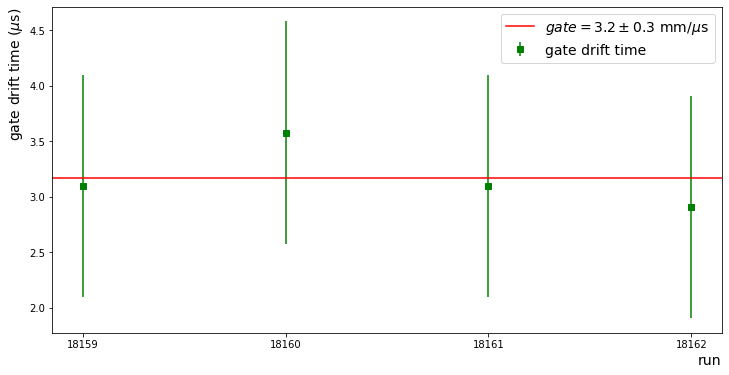

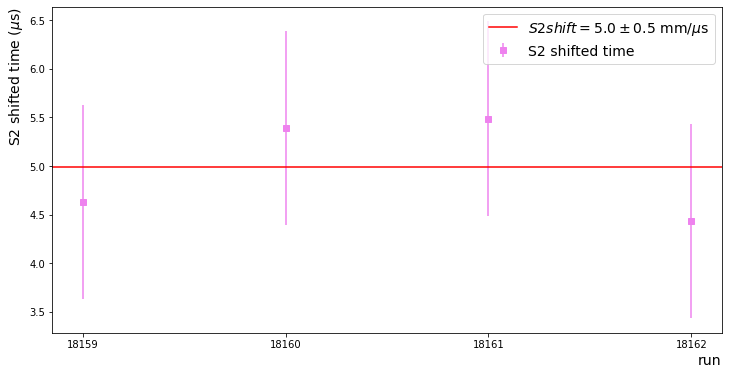

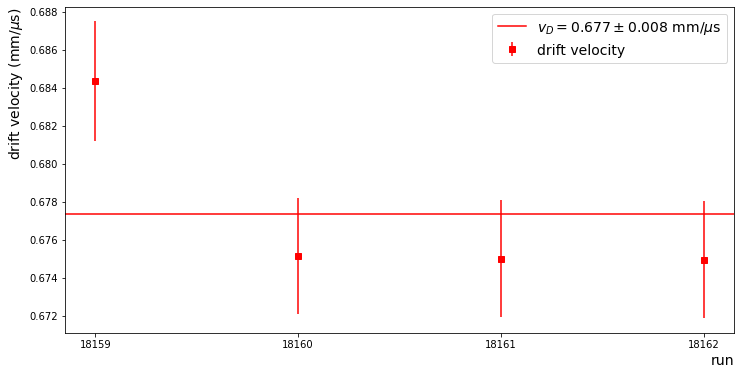

In [12]:
diff1, diff_err1, vd1, vd_err1 = kr_drift_diffusion_analysis(kr_runs_1)

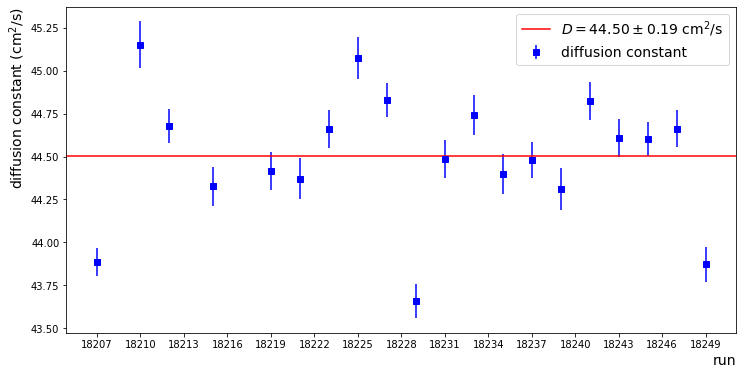

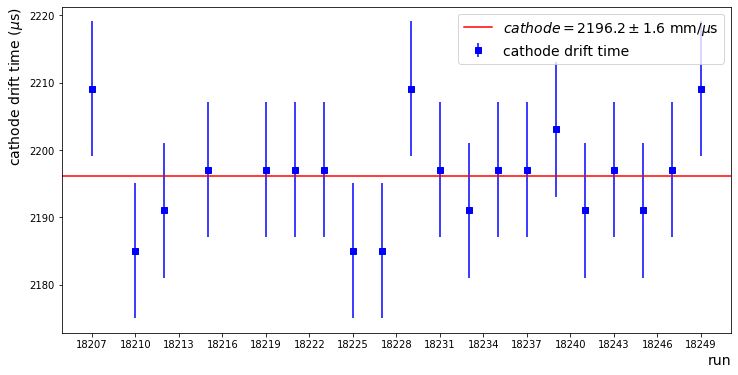

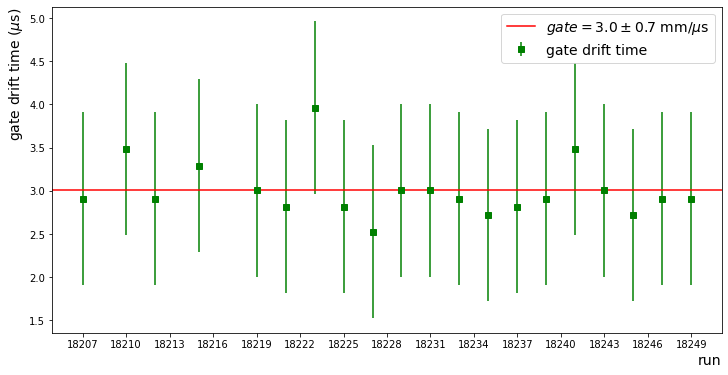

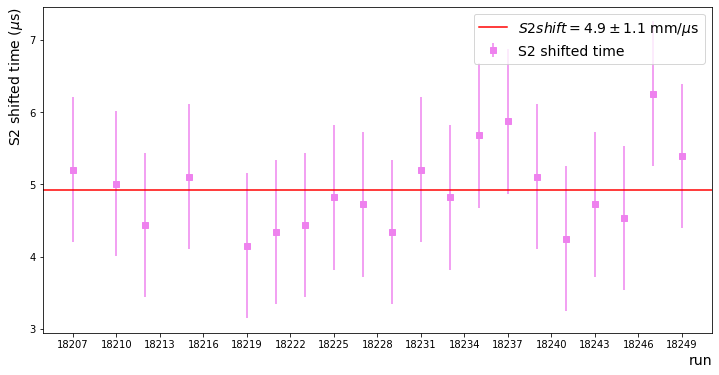

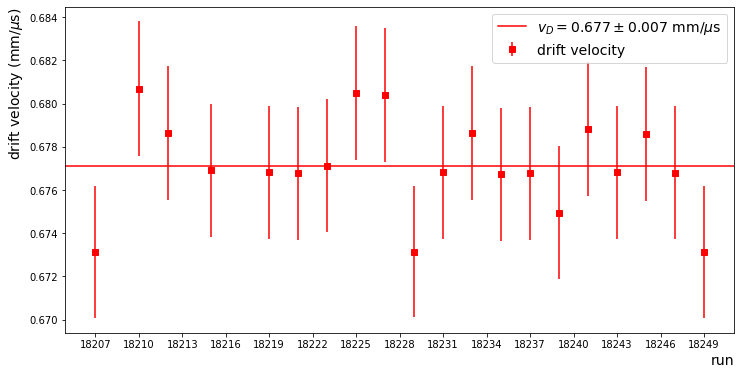

In [13]:
diff2, diff_err2, vd2, vd_err2 = kr_drift_diffusion_analysis(kr_runs_2,runrange=3)

In [14]:
def compare_drift_velocity(vd_SR0,vd_SR0_err,ms=5):
    vd_nT, vd_nT_err = [0.63,0.631], [0.006,0.003]
    vd_nTb, vd_nTb_err = [0.596,0.619, 0.622], [0.005,0.003,0.003]
    field_nT = np.full(len(vd_nT),18.3)
    field_nTb = np.full(len(vd_nTb),18.3)
    field_SR0 = np.full(len(vd_SR0),20.3)
    plt.figure(figsize=(12,6))
    plt.xlabel('drift field (V/cm)',ha='right',x=1)
    plt.ylabel('drift velocity (mm/$\mu$s)',ha='right',y=1)
    #plt.errorbar(field_nTb,vd_nTb,yerr=vd_nTb_err,fmt='o',c='b',ms=ms,lw=2,label='bkg - commissioning')
    plt.errorbar(field_nT, vd_nT, yerr=vd_nT_err,fmt='o',c='r',ms=ms,lw=2,label='Kr83m - commissioning')
    plt.errorbar(field_SR0, vd_SR0, yerr=vd_SR0_err,fmt='o',c='g',ms=ms,lw=2,label='Kr83m - SR0')
    #plt.xlim(0,220)
    #plt.ylim(0.15,1.75)
    plt.legend()

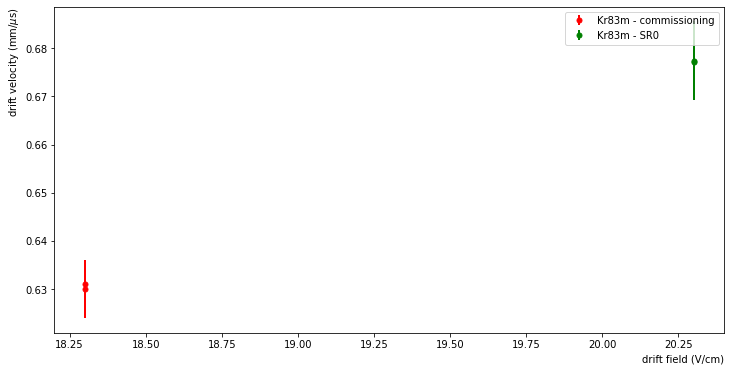

In [15]:
compare_drift_velocity((vd1,vd2),(vd_err1,vd_err2))

In [16]:
def compare_diffusion(d_SR0,d_SR0_err,ms=5):
    diff_nT = [43.0, 42.7]
    diff_nT_err = [0.06, 0.02]
    diff_nTb = [45.3, 49.3, 52.1]
    diff_nTb_err = [0.6, 0.3, 0.3]
    field_nT = np.full(len(diff_nT),18.3)
    field_nTb = np.full(len(diff_nTb),18.3)
    field_SR0 = np.full(len(d_SR0),20.3)
    plt.figure(figsize=(12,6))
    #plt.errorbar(field_nTb,diff_nTb,yerr=diff_nTb_err,fmt='o',ms=ms,color='b',label='bkg - commissioning')
    plt.errorbar(field_nT,diff_nT,yerr=diff_nT_err,fmt='o',ms=ms,color='r',label='Kr83m - commissioning')
    plt.errorbar(field_SR0,d_SR0,yerr=d_SR0_err,fmt='o',ms=ms,color='g',label='Kr83m - SR0')
    plt.xlabel("drift field (V/cm)", ha='right', x=1)
    plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1)
    plt.legend()

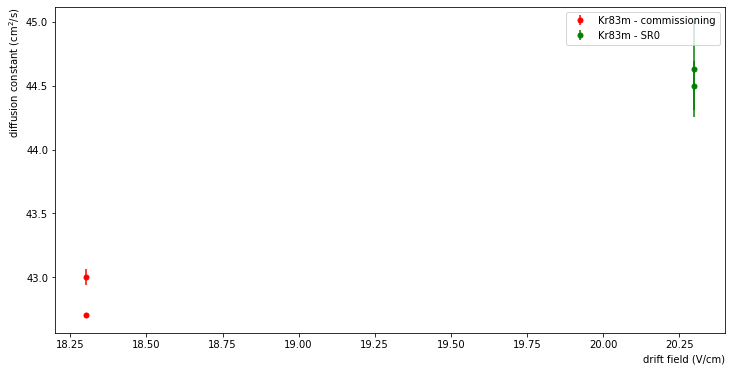

In [17]:
compare_diffusion((diff1,diff2), (diff_err1,diff_err2))